In [1]:
# standard libraries
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# prediction models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

In [2]:
from os import listdir
from os.path import isfile, join

class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class ARFFLoader:
    df = pd.DataFrame()
    
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
    
    def load_data(self):
        files = self.retrieve_files()
        for file in files:
            self.df = pd.concat([self.df, self.load_file(file)])
        self.df=self.df.reset_index(drop=True)
        
    def load_file(self, file_name):
        return pd.DataFrame(arff.loadarff(self.file_path_manager.retrieve_full_path()+'/'+file_name)[0])
 
    def retrieve_files(self):
        full_path = self.file_path_manager.retrieve_full_path()
        return [f for f in os.listdir(full_path) if os.path.isfile(join(full_path, f))]
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)

In [4]:
def clean_df(df: pd.DataFrame):
    df['bankrupt'] = ( df['class'] == df['class'][df.shape[0]-1] ).astype(int)
    df = df.drop('class', axis=1)
    return df;

In [5]:
path_manager = FilePathManager('data')
loader = ARFFLoader(path_manager)
loader.load_data()

In [ ]:
loader.get_df()

### Percentage of missing data

In [ ]:
loader.get_df()['class'].value_counts()

In [ ]:
2091/(41314+2091)

In [ ]:
2091/(2091+0)

In [ ]:
(2*(1*(.04817417348231771*1.0)))/(.04817417348231771+1)

In [ ]:
missing = loader.get_df().isnull().sum()
pct_missing = missing/loader.size()*100
pct_missing.sort_values(ascending=False).head(15)

## Modeling

In [6]:
from abc import ABC, abstractmethod

class BaseImputer:
    @abstractmethod
    def fit(self, X, y=None):
        pass
    
    @abstractmethod
    def transform(self, X):
        pass

class BaseModel:
    @abstractmethod
    def fit(self, X, y, sample_weight=None):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass

In [7]:
class XGBModel:
    _model = None
    
    def __init__(self, params, num_round: int = 100):
        self._params = params
        self._num_round = num_round
        
    def fit(self, X, y, sample_weight=None):
        dtrain = xgb.DMatrix(X, label = y)
        self._model = xgb.train(self._params, dtrain)
        
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self._model.predict(dtest)
        

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

In [9]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, scaler = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train):
        if self._scaler is not None:
            self._scaler.fit(train)
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame):
        if self._scaler is not None:
            X = pd.DataFrame(self._scaler.transform(X), columns = self._X.columns)
        return X
    
    def prepare(self):
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train)
        self._X_train_fitted = self._scale_data(X_train)
        self._X_test_fitted = self._scale_data(X_test)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self):
        self._model.fit(self.X_train, self.y_train)
        self._y_preds = self._model.predict(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test))
       
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None):
        pass
        

In [10]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None, 
                 beta: int = 1, 
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler)
        self.beta = beta
        self.classification = classification
    
    def metrics(self, y_true = None, y_pred = None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds
        if type(y_pred[0]) is np.int32: # RandomForest, xbg binary:hinge, xbg multi:softmax
            return ({'matrix': confusion_matrix(y_true, y_pred), 
                'accuracy': accuracy_score(y_true, y_pred), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                 'f1': f1_score(y_true, y_pred),
                'f{}'.format(self.beta) : fbeta_score(y_true, y_pred, average=self.classification, beta=self.beta) } )
        else: # to handle xbg binary:logistic with class_weights
            y_pred = pd.Series( (y_pred>0.5).astype(int), index=y_true.index) 
            return ({'matrix': confusion_matrix(y_true, y_pred), 
                'accuracy': accuracy_score(y_true, y_pred), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                 'f1': f1_score(y_true, y_pred),
                'f{}'.format(self.beta) : fbeta_score(y_true, y_pred, average=self.classification, beta=self.beta) } )
        

### RandomForest

In [ ]:
simple_impute_model = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                               StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                               SimpleImputer(missing_values=np.nan, strategy='median'),
                               RandomForestClassifier(random_state=0, class_weight='balanced', max_depth=13),
                               StandardScaler(), beta=2)

In [ ]:
simple_impute_model.prepare_and_train()

In [ ]:
simple_impute_model.test()

### Iterative Model

In [ ]:
iterative_impute_model = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                               StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                               IterativeImputer(missing_values=np.nan, random_state=1234),
                               RandomForestClassifier(random_state=0, class_weight={0: .02, 1: .98}, max_depth=13),
                               StandardScaler(), beta=2)

In [ ]:
iterative_impute_model.prepare_and_train()

In [ ]:
iterative_impute_model.test()

### Knn Imputation

In [ ]:
knn_impute_model = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                            StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234),
                            KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'),
                            RandomForestClassifier(random_state=0, class_weight='balanced'),
                            StandardScaler(), beta=2)

In [ ]:
knn_impute_model.train()

In [ ]:
knn_impute_model._accuracy

In [ ]:
knn_impute_model._f1

In [ ]:
knn_impute_model.test()

### XGB todo: figure out how to run class_weight with xgb
todo: Should we just remove class = 'balanced' for Random Forest?

### XGB Simple Imputer

In [ ]:
num_round = 1000
params = {
    'max_depth': 15,
    'objective': 'multi:softmax',
    'num_class': 2,
    'eta': 0.3
}

In [ ]:
xgb_simple_imputer = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                                            StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                            SimpleImputer(missing_values=np.nan, strategy='median'),
                                            XGBModel(params, num_round),
                                            StandardScaler(),
                                            beta=2)

In [ ]:
xgb_simple_imputer.prepare_and_train();

In [ ]:
xgb_simple_imputer.metrics()

In [ ]:
xgb_simple_imputer.test()

### XGB Iterative

In [ ]:
params2 = {
    'max_depth': 15,
    'objective': 'multi:softmax',
    'num_class': 2,
    'eta': 0.3
}

In [ ]:
xgb_iterative_imputer = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                                 StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                 IterativeImputer(missing_values=np.nan, random_state=1234),
                                 XGBModel(params2, num_round),
                                 StandardScaler(), 
                                 beta=2)

In [ ]:
xgb_iterative_imputer.prepare_and_train()

In [ ]:
xgb_iterative_imputer.test()

### No Imputer

In [ ]:
xgb_no_imputer = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                                        StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                        None,
                                        XGBModel(params2, num_round),
                                        StandardScaler(), beta=2)

In [ ]:
xgb_no_imputer.prepare_and_train()

In [ ]:
xgb_no_imputer._accuracy

In [ ]:
xgb_no_imputer._f1

In [ ]:
xgb_no_imputer.test()

### Cost Matrix
False Negative = "Incorrectly predicting Bankruptcy to be Solvency" which is related to Recall.  The cost of a False Negative is assumed to be a 100% loss = 1

False Positive = "Incorrectly predicting Solvency to be Bankruptcy" which is related to Precision.  The team assumes a False Positive occurs for a company that is already under significant financial duress, likely with investor losses of approximately 50% = 0.5  

In [11]:
cost_matrix = np.array([[0,0.5],[1,0]])
cost_matrix

array([[0. , 0.5],
       [1. , 0. ]])

### Examining Depth vs Metrics

In [12]:
forest_modeling = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           IterativeImputer(missing_values=np.nan, random_state=1234),
                           None,
                           StandardScaler(), beta=2)
forest_modeling.prepare()

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\sklearn\impute\_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


#### Random Forest with no class weights

In [36]:
results0 = pd.DataFrame()
for i in range(4,21):
    forest_modeling.model = RandomForestClassifier(random_state=0, class_weight=None, max_depth = i)
    train_out = forest_modeling.train()
    test_out = forest_modeling.test()
    results0 = results0.append({'max_depth': forest_modeling.model.max_depth,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],
                    'f2_train': train_out['f2'],          
                    'f2_test': test_out['f2'],           
                    '%_invest_loss_train': np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': np.sum(cost_matrix*test_out['matrix'])/np.sum(train_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
results0

,max_depth,accuracy_train,accuracy_test,f1_train,f1_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,4.0,0.951815,0.951851,0.000000,0.000000,0.000000,0.000000,0.048185,0.020637
1,5.0,0.952572,0.952619,0.030935,0.031397,0.019561,0.019857,0.047428,0.020307
2,6.0,0.955106,0.954846,0.127877,0.119760,0.083949,0.078462,0.044894,0.019336
3,7.0,0.957509,0.956151,0.211362,0.166423,0.143473,0.111068,0.042491,0.018777
4,8.0,0.962709,0.958916,0.368802,0.257975,0.267496,0.178709,0.037291,0.017592
5,9.0,0.965145,0.960759,0.433387,0.314094,0.323431,0.222772,0.034855,0.016802
6,10.0,0.967613,0.962064,0.493827,0.353403,0.378788,0.255198,0.032387,0.016226
7,11.0,0.969424,0.962448,0.535268,0.367400,0.418557,0.267521,0.030576,0.016029
8,12.0,0.971958,0.962832,0.589595,0.377892,0.473098,0.276420,0.028042,0.015864
9,13.0,0.974789,0.962679,0.645698,0.378517,0.532499,0.277882,0.025211,0.015881


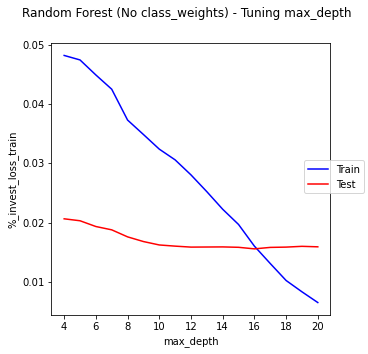

In [37]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('Random Forest (No class_weights) - Tuning max_depth')

sns.lineplot(data=results0, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(data=results0, x='max_depth', y='%_invest_loss_test', color='red')

fig.legend(['Train','Test'], loc='right')
plt.show()

#### XGBoost with no rebalanced class_weight

In [41]:
results00 = pd.DataFrame()
for i in range(4,21):
    params = {
    'max_depth': i,
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'num_class': 2,
    'eta': 0.3,
    }
    forest_modeling.model = XGBModel(params) #num_round
    train_out = forest_modeling.train()
    test_out = forest_modeling.test()
    results00 = results00.append({'max_depth': i,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f2_train': train_out['f2'],            
                    'f2_test': test_out['f2'], 
                    '%_invest_loss_train': np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': np.sum(cost_matrix*test_out['matrix'])/np.sum(train_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
results00

,max_depth,accuracy_train,accuracy_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,4.0,0.967087,0.964752,0.377834,0.323661,0.032650,0.015008
1,5.0,0.967877,0.964906,0.387280,0.327138,0.032057,0.014943
2,6.0,0.969720,0.965597,0.431464,0.347505,0.030116,0.014597
3,7.0,0.972221,0.966595,0.482429,0.369757,0.027680,0.014169
4,8.0,0.976072,0.966365,0.561866,0.380256,0.023846,0.014103
5,9.0,0.980186,0.967363,0.643770,0.418773,0.019748,0.013494
6,10.0,0.984794,0.967977,0.732080,0.433453,0.015157,0.013215
7,11.0,0.988645,0.966441,0.802151,0.422939,0.011355,0.013626
8,12.0,0.990949,0.966902,0.844331,0.429799,0.009035,0.013461
9,13.0,0.994240,0.967593,0.902477,0.448878,0.005743,0.013116


#### Overfits faster than Random Forest

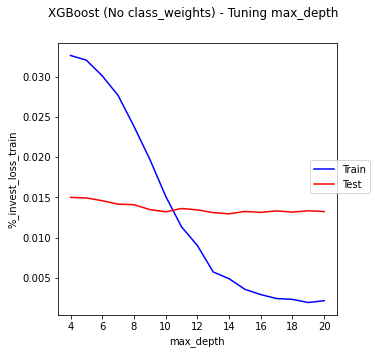

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('XGBoost (No class_weights) - Tuning max_depth')

sns.lineplot(data=results00, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(data=results00, x='max_depth', y='%_invest_loss_test', color='red')

fig.legend(['Train','Test'], loc='right')
plt.show()

#### Random Forest with rebalanced classes

In [20]:
results = pd.DataFrame()
for i in range(4,21):
    forest_modeling.model = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = i)
    train_out = forest_modeling.train()
    test_out = forest_modeling.test()
    results = results.append({'max_depth': forest_modeling.model.max_depth,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],
                    'f2_train': train_out['f2'],          
                    'f2_test': test_out['f2'],           
                    '%_invest_loss_train': np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': np.sum(cost_matrix*test_out['matrix'])/np.sum(train_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
results

,max_depth,accuracy_train,accuracy_test,f1_train,f1_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,4.0,0.771418,0.762709,0.240402,0.227114,0.405984,0.386120,0.120298,0.053698
1,5.0,0.793536,0.783443,0.264682,0.244373,0.436818,0.406200,0.108745,0.049222
2,6.0,0.828128,0.816080,0.308894,0.273582,0.488366,0.435496,0.090824,0.042310
3,7.0,0.869335,0.850637,0.376962,0.303117,0.557878,0.452697,0.069661,0.035365
4,8.0,0.896521,0.874597,0.437164,0.325485,0.611846,0.457927,0.055738,0.030708
5,9.0,0.918968,0.896099,0.504428,0.349832,0.669338,0.459364,0.043988,0.026594
6,10.0,0.941875,0.917371,0.594023,0.392777,0.738961,0.476321,0.031893,0.022299
7,11.0,0.958497,0.931347,0.676915,0.411842,0.796263,0.460159,0.023105,0.019880
8,12.0,0.967844,0.939794,0.734005,0.422680,0.835710,0.443038,0.017987,0.018497
9,13.0,0.976566,0.945938,0.795167,0.434084,0.878241,0.432000,0.013067,0.017460


#### Minimum investing loss of ~2% without overfitting Random Forest is at max_depth = 12

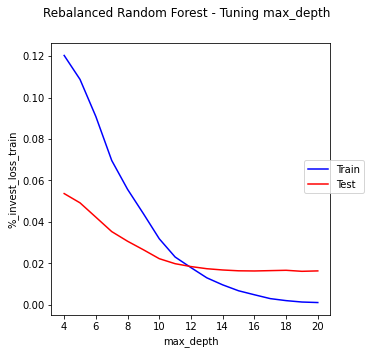

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('Rebalanced Random Forest - Tuning max_depth')

sns.lineplot(data=results, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(data=results, x='max_depth', y='%_invest_loss_test', color='red')

fig.legend(['Train','Test'], loc='right')
plt.show()

#### XG Boost with rebalanced classes

In [22]:
df = loader.get_df()

In [23]:
# scale_pos_weight
np.bincount(df['bankrupt'])[0]/np.bincount(df['bankrupt'])[1]

19.758010521281683

In [25]:
results2 = pd.DataFrame()
for i in range(2,20):
    params = {
    'max_depth': i,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    #'num_class': 2,
    'eta': 0.3,
    'scale_pos_weight': 19.758 
    }
    forest_modeling.model = XGBModel(params) #num_round
    train_out = forest_modeling.train()
    test_out = forest_modeling.test()
    results2 = results2.append({'max_depth': i,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f2_train': train_out['f2'],            
                    'f2_test': test_out['f2'], 
                    '%_invest_loss_train': np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': np.sum(cost_matrix*test_out['matrix'])/np.sum(train_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
results2

,max_depth,accuracy_train,accuracy_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,2.0,0.795741,0.787590,0.436526,0.416891,0.107774,0.048185
1,3.0,0.810651,0.801106,0.476665,0.450962,0.099101,0.044844
2,4.0,0.828457,0.819920,0.519957,0.477603,0.089112,0.040697
3,5.0,0.847941,0.832821,0.562102,0.484704,0.078613,0.038113
4,6.0,0.885594,0.867148,0.635545,0.514625,0.059227,0.031086
5,7.0,0.904815,0.884810,0.689141,0.532930,0.048876,0.027466
6,8.0,0.915775,0.892720,0.722251,0.532885,0.042968,0.026001
7,9.0,0.939966,0.912533,0.792683,0.546066,0.030362,0.022118
8,10.0,0.955633,0.922977,0.840273,0.548186,0.022364,0.020159
9,11.0,0.968765,0.935724,0.880926,0.549656,0.015798,0.017790


#### Minimum investing loss of ~2% without overfitting rebalanced XGBoost is at max_depth = 10
Very similar to rebalanced Random Forest above

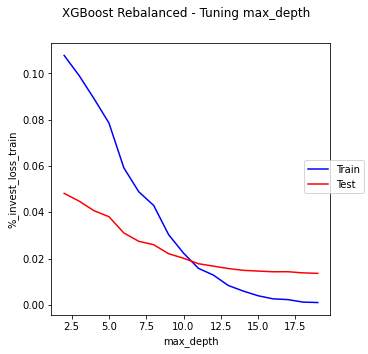

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('XGBoost Rebalanced - Tuning max_depth')

sns.lineplot(data=results2, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(data=results2, x='max_depth', y='%_invest_loss_test', color='red')

fig.legend(['Train','Test'], loc='right')
plt.show()

In [28]:
results3 = pd.DataFrame()
for i in range(0,10):
    eta = 0.1 + i*0.1
    params = {
    'max_depth': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    #'num_class': 2,
    'scale_pos_weight': 19.758, 
    'eta': eta
    }
    forest_modeling.model = XGBModel(params) #num_round
    train_out = forest_modeling.train()
    test_out = forest_modeling.test()
    results3 = results3.append({'eta': eta,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f2_train': train_out['f2'],            
                    'f2_test': test_out['f2'], 
                    '%_invest_loss_train': np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': np.sum(cost_matrix*test_out['matrix'])/np.sum(train_out['matrix'])}, 
                    ignore_index = True)
    print("eta =",eta,"complete")
clear_output()
results3

,eta,accuracy_train,accuracy_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,0.1,0.934272,0.907541,0.764802,0.542016,0.033785,0.023105
1,0.2,0.944969,0.917217,0.805388,0.544541,0.027894,0.021278
2,0.3,0.955633,0.922977,0.840273,0.548186,0.022364,0.020159
3,0.4,0.959681,0.928736,0.853558,0.545505,0.020291,0.019139
4,0.5,0.975842,0.939333,0.908075,0.531978,0.012112,0.017378
5,0.6,0.986703,0.946322,0.947695,0.525107,0.006648,0.016177
6,0.7,0.983543,0.946245,0.935661,0.539350,0.008245,0.015996
7,0.8,0.988842,0.945323,0.955738,0.524230,0.005579,0.016374
8,0.9,0.992825,0.952311,0.971080,0.516804,0.003588,0.015173
9,1.0,0.995195,0.949009,0.980445,0.491001,0.002403,0.016127


### Minimum investing loss without overfitting balanced XGBoost is at eta = 0.4

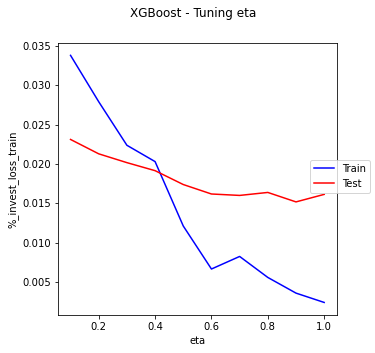

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('XGBoost - Tuning eta')

sns.lineplot(data=results3, x='eta', y='%_invest_loss_train', color='blue')
sns.lineplot(data=results3, x='eta', y='%_invest_loss_test', color='red')

fig.legend(['Train','Test'], loc='right')
plt.show()

In [30]:
XGB_Classifier_Model = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           IterativeImputer(missing_values=np.nan, random_state=1234),
                           None,
                           StandardScaler(), beta=2)
XGB_Classifier_Model.prepare()

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\sklearn\impute\_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### ?? XGBClassifier is completely overfitting the model using the same parameters tuned with xgb ??

In [32]:
XGB_Classifier_Model.model = XGBClassifier(max_depth=10, eval_metric='mlogloss', eta=0.4, scale_pos_weight= 19.758)
xgb_train1 = XGB_Classifier_Model.train()
xgb_train1

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'matrix': array([[28919,     0],
        [    0,  1464]], dtype=int64),
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0,
 'f2': 1.0}

In [33]:
invest_loss_train1 = np.sum(cost_matrix*xgb_train1['matrix'])/np.sum(xgb_train1['matrix'])
invest_loss_train1

0.0

In [34]:
xgb_test1 = XGB_Classifier_Model.test()
xgb_test1

{'matrix': array([[12280,   115],
        [  317,   310]], dtype=int64),
 'accuracy': 0.9668253724466288,
 'precision': 0.7294117647058823,
 'recall': 0.4944178628389155,
 'f1': 0.5893536121673004,
 'f2': 0.5284691442209343}

In [35]:
invest_loss_test1 = np.sum(cost_matrix*xgb_test1['matrix'])/np.sum(xgb_test1['matrix'])
invest_loss_test1

0.02875902319152204

### Best XGB 

In [ ]:
'''params2 = {
    'max_depth': 11,
    'objective': 'binary:hinge', #'multi:softmax',
    #'num_class': 2,
    'eta': 0.3
}

please_work = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                                 StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                 IterativeImputer(missing_values=np.nan, random_state=1234),
                                 XGBModel(params2),
                                 StandardScaler(), 
                                 beta=2)'''

In [ ]:
#please_work.prepare_and_train() # eta=0.6

In [ ]:
#please_work.test() # eta=0.6

In [ ]:
#please_work.prepare_and_train() # eta=0.3

In [ ]:
#please_work.test() # eta=0.3